In [1]:
import os
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import cuda, device, Tensor, save, load, stack, zeros, vstack, squeeze, tensor, clamp_
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.exq_net_v1 import ExquisiteNetV1

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
num_data = 1

# training_data is NOT normalized
# but no need for further normalization since Dataloader inside the train_model automatically does that
training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

# not normalized
input = training_data.data[:num_data]
labels_li = training_data.targets[:num_data]

# # not normalized (values 0 ~ 255)
# print(training_data.data)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10
Finished epoch:  11
Finished epoch:  12
Finished epoch:  13
Finished epoch:  14
Finished epoch:  15
Finished epoch:  16
Finished epoch:  17
Finished epoch:  18
Finished epoch:  19
Finished epoch:  20


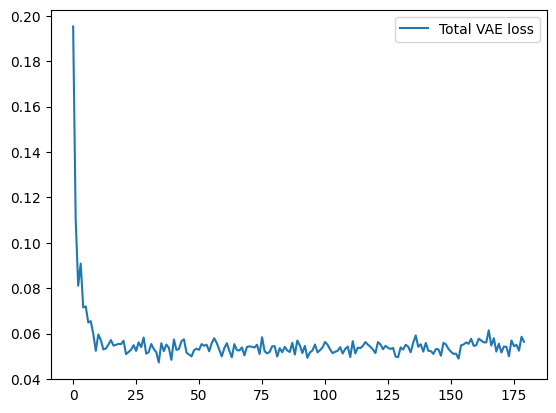

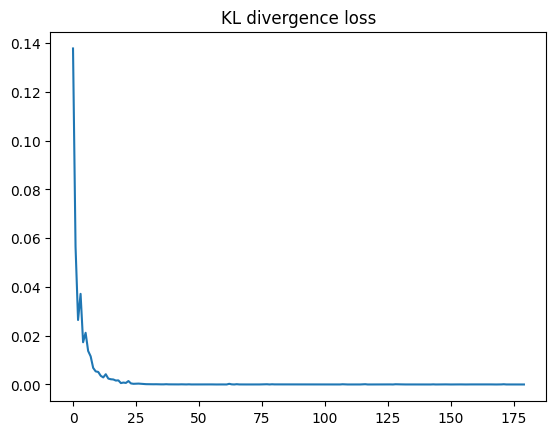

In [3]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 64
epoch = 20
learning_rate = 0.001

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

if os.path.exists(model_path):
    cvae = load(model_path)
else:
    cvae = ConditionalVae(dim_encoding=3).to(device)

    vae_model, vae_loss_li, kl_loss_li = cvae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(cvae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels_li,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

Input shape:  torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0

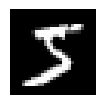

In [4]:
# check original image
input, label = training_data[0]

print("Input shape: ", input.shape)
print(input)

print("Label: ", label)

plt.figure()
plt.subplot(151)
plt.axis('off')
plt.imshow(np.squeeze(input.detach().numpy()), cmap='gray')

Reconstructed shape:  torch.Size([1, 1, 28, 28])
tensor([[[[1.1877e-04, 1.1560e-04, 1.1997e-04, 1.1444e-04, 1.2071e-04,
           1.0734e-04, 1.1988e-04, 1.1223e-04, 1.1459e-04, 1.2021e-04,
           1.1307e-04, 1.1453e-04, 1.1916e-04, 1.2121e-04, 1.0779e-04,
           1.0698e-04, 1.2810e-04, 1.2211e-04, 1.2031e-04, 1.1614e-04,
           1.1703e-04, 1.1248e-04, 1.2035e-04, 1.1841e-04, 1.1752e-04,
           1.2075e-04, 1.1847e-04, 1.1363e-04],
          [1.1631e-04, 1.1962e-04, 1.1540e-04, 1.1302e-04, 1.1852e-04,
           1.1971e-04, 1.1930e-04, 1.2889e-04, 1.2715e-04, 1.4446e-04,
           1.7004e-04, 1.5227e-04, 1.5808e-04, 1.6009e-04, 1.5370e-04,
           1.8309e-04, 1.5454e-04, 1.7244e-04, 1.5374e-04, 1.5302e-04,
           1.4621e-04, 1.3076e-04, 1.2984e-04, 1.2332e-04, 1.1739e-04,
           1.1842e-04, 1.1359e-04, 1.0896e-04],
          [1.1791e-04, 1.1936e-04, 1.1529e-04, 1.2157e-04, 1.2316e-04,
           1.1432e-04, 1.4703e-04, 1.4020e-04, 1.5417e-04, 1.6808e-04,
   

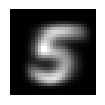

In [5]:
# check reconstructed image
input, label = training_data[0]
input = input.to(device)
label = tensor(label).to(device)
output = cvae(input, label)
print("Reconstructed shape: ", output.shape)
print(output)

plt.figure()
plt.subplot(151)
plt.axis('off')
squeezed_img = np.squeeze(output.cpu().detach().numpy())
plt.imshow(squeezed_img, cmap='gray')

Randomly sampled shape:  torch.Size([1, 1, 28, 28])
tensor([[[[1.2644e-04, 1.2329e-04, 1.2787e-04, 1.2179e-04, 1.2840e-04,
           1.1441e-04, 1.2778e-04, 1.1950e-04, 1.2215e-04, 1.2806e-04,
           1.2050e-04, 1.2201e-04, 1.2673e-04, 1.2923e-04, 1.1489e-04,
           1.1420e-04, 1.3656e-04, 1.3019e-04, 1.2811e-04, 1.2384e-04,
           1.2457e-04, 1.1977e-04, 1.2793e-04, 1.2599e-04, 1.2514e-04,
           1.2845e-04, 1.2590e-04, 1.2122e-04],
          [1.2388e-04, 1.2759e-04, 1.2282e-04, 1.2034e-04, 1.2611e-04,
           1.2749e-04, 1.2681e-04, 1.3702e-04, 1.3524e-04, 1.5396e-04,
           1.8097e-04, 1.6219e-04, 1.6838e-04, 1.7070e-04, 1.6368e-04,
           1.9421e-04, 1.6430e-04, 1.8343e-04, 1.6388e-04, 1.6274e-04,
           1.5562e-04, 1.3884e-04, 1.3833e-04, 1.3127e-04, 1.2514e-04,
           1.2604e-04, 1.2119e-04, 1.1609e-04],
          [1.2596e-04, 1.2727e-04, 1.2262e-04, 1.2935e-04, 1.3136e-04,
           1.2186e-04, 1.5630e-04, 1.4910e-04, 1.6351e-04, 1.7821e-04,


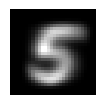

In [6]:
# check randomly sampled image
image = cvae.generate_data(n_samples=1, target_label=5)
print("Randomly sampled shape: ", image.shape)
print(image)

plt.figure()
plt.subplot(151)
plt.axis('off')
squeezed_img = np.squeeze(image.cpu().detach().numpy())
plt.imshow(squeezed_img, cmap='gray')

In [7]:
# # simple classifier for performance evaluation
# model = "classifier"
# dataset = "mnist"
# batch_size = 64
# epoch = 10
# 
# classifier_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}.pt"
# 
# # if os.path.exists(classifier_path):
# #     classifier = load(classifier_path)
# # else:
# classifier = MNISTClassifier(input_size=784, num_classes=10)
# classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
# accuracy = classifier.test_model(testing_data)
# print("Test accuracy: ", accuracy)
# save(classifier, classifier_path)

In [15]:
# generate images for training on classifier
data_count = 60000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
batch_size = 60

images_li = []
labels_li = []
for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    to_iterate = int(num_samples_to_generate / batch_size)
    for i in range(to_iterate):
        image = cvae.generate_data(n_samples=batch_size, target_label=label_idx).cpu().detach()
        images_li.append(image)
        labels_li.append(torch.full((batch_size,), label_idx))

print(len(images_li))
print(images_li[0].shape)
print(images_li[0])

print(len(labels_li))
print(labels_li[0].shape)
# print(labels_li[0])

1000
torch.Size([60, 1, 28, 28])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...

In [29]:
import random

# shuffle
pairs = list(zip(images_li, labels_li))
random.shuffle(pairs)
shuffled_image_tensors, shuffled_labels = zip(*pairs)
images_li = list(shuffled_image_tensors)
labels_li = list(shuffled_labels)

print(labels_li[0])

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [30]:
# train CNN classifier on generated images
classifier = ExquisiteNetV1(class_num=10, img_channels=1)
classifier.to(device)
classifier.train_model_syn_image(input_li=images_li, labels_li=labels_li, epochs=20, learning_rate=0.01)

Epoch done:  1
Training loss:  0.6217139959335327
Epoch done:  2
Training loss:  0.306334525346756
Epoch done:  3
Training loss:  0.3599604368209839
Epoch done:  4
Training loss:  0.2007782906293869
Epoch done:  5
Training loss:  0.16638712584972382
Epoch done:  6
Training loss:  0.029534822329878807
Epoch done:  7
Training loss:  0.009805852547287941
Epoch done:  8
Training loss:  0.001216304604895413
Epoch done:  9
Training loss:  0.0007684971787966788
Epoch done:  10
Training loss:  0.00016017068992368877
Epoch done:  11
Training loss:  0.0004472899599932134
Epoch done:  12
Training loss:  0.00026011146837845445
Epoch done:  13
Training loss:  7.499237835872918e-05
Epoch done:  14
Training loss:  7.142667163861915e-05
Epoch done:  15
Training loss:  2.51634992309846e-05
Epoch done:  16
Training loss:  1.7641432350501418e-05
Epoch done:  17
Training loss:  4.8443580453749746e-05
Epoch done:  18
Training loss:  2.3247532226378098e-05
Epoch done:  19
Training loss:  4.4229407649254426e

In [31]:
# test on real data
accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)

print(accuracy)
print(loss)
print(f1_macro)
print(f1_micro)

# # test on synthetic data
# data_count = 10000
# ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# images = []
# labels = []
# for label_idx, ratio in enumerate(ratios):
#     num_samples_to_generate = int(data_count * ratio)
#     images.append(
#         cvae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach()
#     )
#     label = zeros((num_samples_to_generate, 10), device=device)
#     label[:, label_idx] = 1
#     labels.append(label.cpu().detach())
# final_images = vstack(images)
# final_labels = vstack(labels)
# 
# testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=False, download=True,
#                                                   transform=torchvision.transforms.ToTensor())
# testing_data.data = squeeze(final_images, dim=1)
# testing_data.targets = final_labels.argmax(dim=1)
# 
# accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)
# 
# print(accuracy)
# print(loss)
# print(f1_macro)
# print(f1_micro)

0.0778
0.4519887882068547
0.06830612361427668
0.0778
